# **Project-3**

***Project Title:*** Customer Segmentation

***Project Description:*** In this project, you will build a machine learning model to segment customers based on their demographics and spending behavior. The data set includes information on customers' age, gender, annual income, and spending score (a metric assigned by the mall based on how much customers spend and how often they visit).

***Dataset Details:*** The data set contains 200 records of customers.

***Datasets Location:*** Canvas -> Modules -> Week 13 -> Dataset -> **"customers.csv"**.

***Tasks:***

1) *Data Exploration and Preprocessing:* You will explore the data set, handle missing values, perform feature engineering, and preprocess the data to get it ready for model building.

2) *Model Building:* You will train and evaluate several unsupervised clustering models on the preprocessed data set, including k-means clustering and DBSCAN.

3) *Model Evaluation:* You will evaluate the clustering results using silhouette and inertia scores. You will also analyze the resulting customer segments and interpret their characteristics.

4) *Deployment:* Once you have identified the customer segments, you can use them to personalize marketing campaigns, improve customer retention, and optimize product recommendations.

This project will give you hands-on experience with unsupervised clustering, data preprocessing, and model evaluation. It also has real-world applications in marketing and e-commerce, where customer segmentation can help businesses tailor their offerings to different customer groups.


# **Data Exploration and Preprocessing**
*You will explore the data set, handle missing values, perform feature engineering, and preprocess the data to get it ready for model building.*

In [4]:
import pandas as pd

df = pd.read_csv("customers.csv").drop("CustomerID", axis=1)
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


Dropped the customerID column because that was just indexing of the data, customer ID can be gotten by index+1

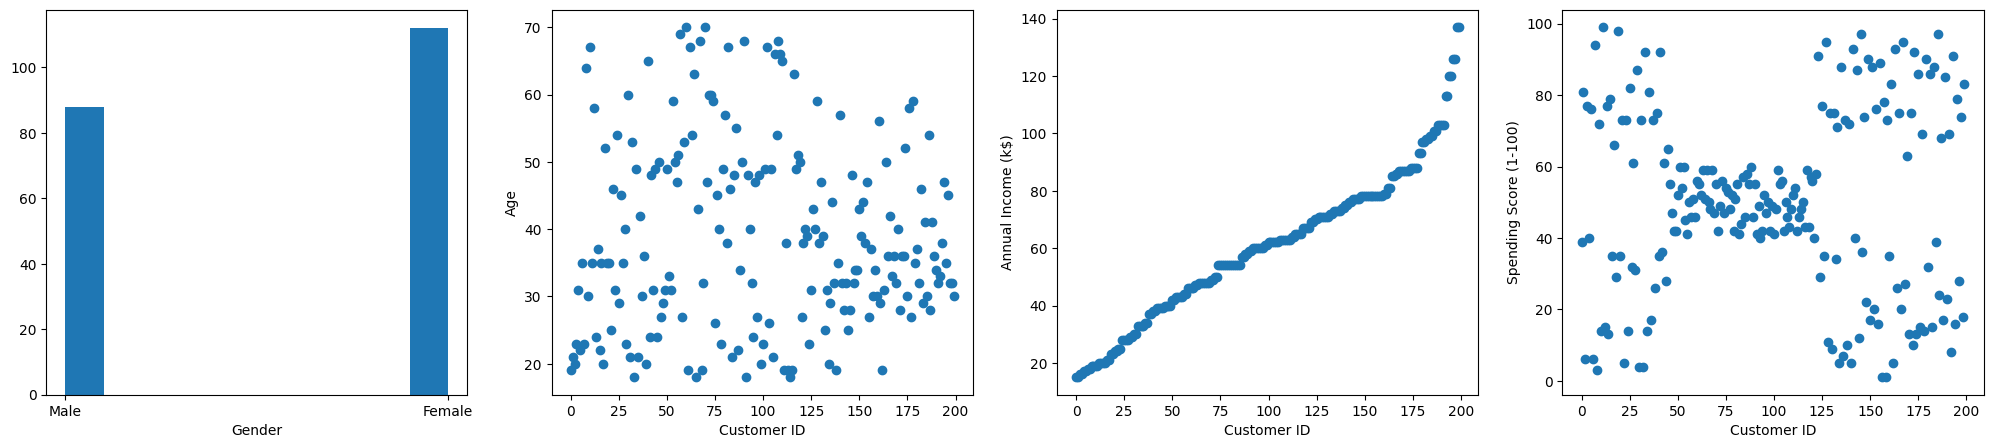

In [5]:
from matplotlib import pyplot as plt

#First Graphs to see what the data looks like 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,5))
axes = axes.flatten()

for (i, col) in enumerate(df.columns):
    if (col == "Gender"):
        axes[i].hist(df[col])
        axes[i].set_xlabel(col)
        continue
    axes[i].scatter(x=df.index, y=df[col])
    axes[i].set_ylabel(col)
    axes[i].set_xlabel("Customer ID")

plt.show()

The data is not really interesting for gender but for the other three, annual income and spending score are more interesting as clustering can be done on spending score and annual income seems to be an increasing scale

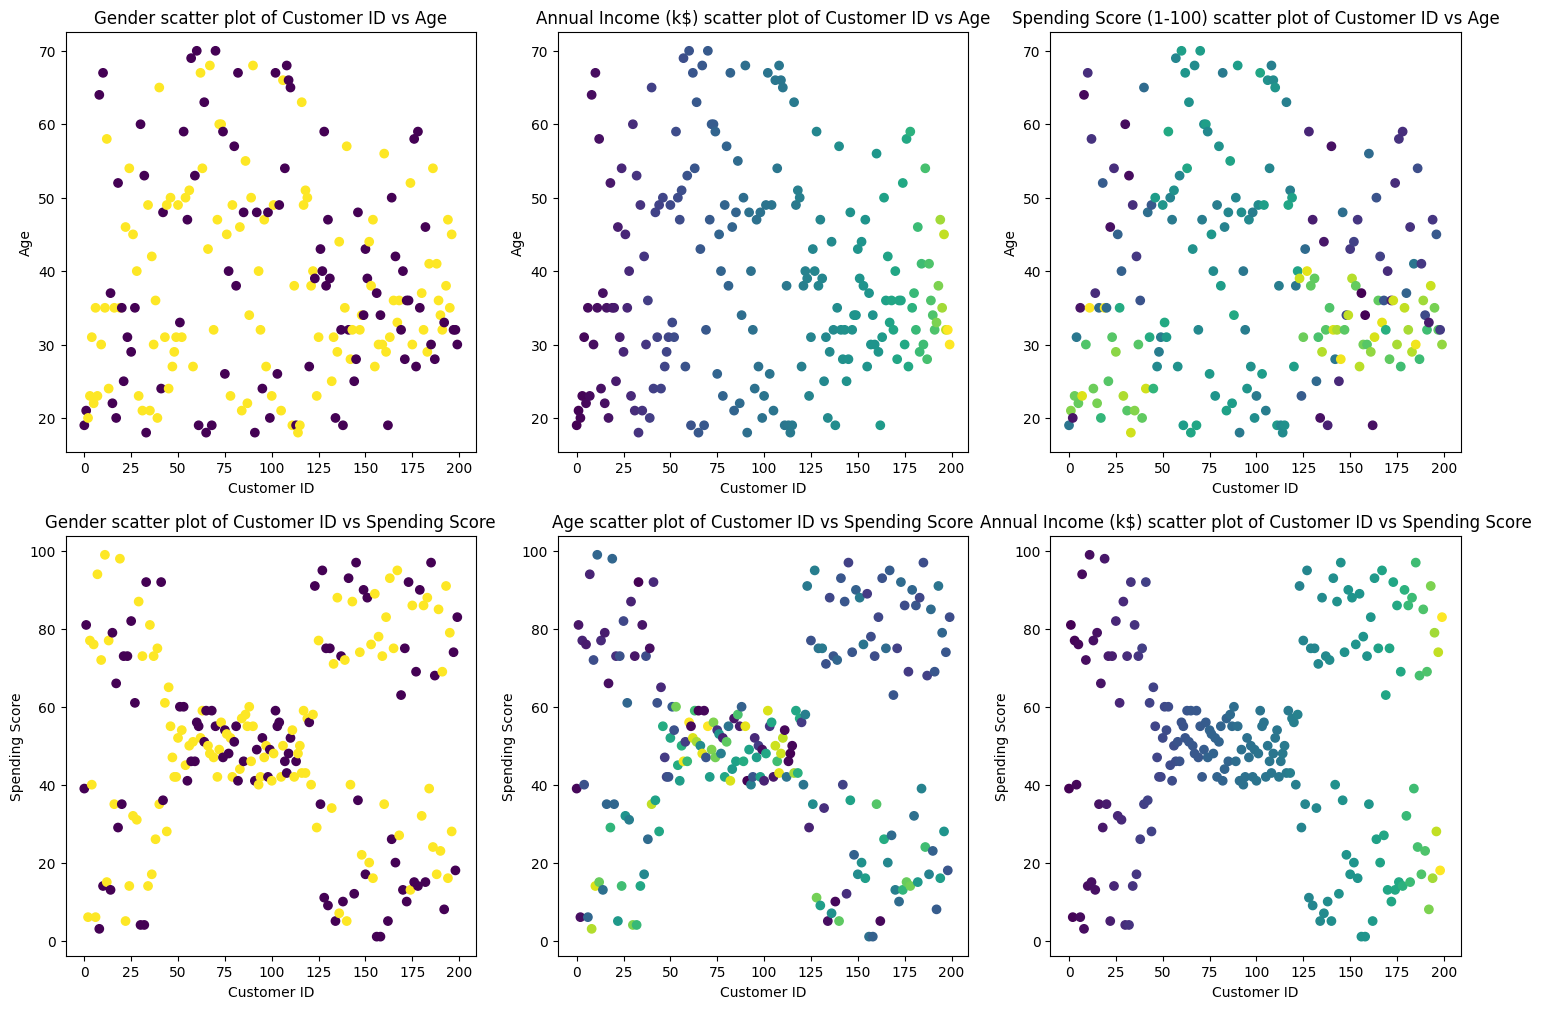

In [6]:
gender_col = df['Gender'].map({'Male': 0, 'Female': 1})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axes = axes.flatten()

custom_col =df.columns.drop("Age")

for (i, col) in enumerate(custom_col):
    axes[i].set_title(custom_col[i] + " scatter plot of Customer ID vs Age")
    axes[i].set_ylabel("Age")
    axes[i].set_xlabel("Customer ID")
    if (col == "Gender"): 
        axes[i].scatter(x=df.index, y=df["Age"], c=gender_col)
        continue
    axes[i].scatter(x=df.index, y=df["Age"], c=df[col])
    
custom_col = df.columns.drop("Spending Score (1-100)")

for (i, col) in enumerate(custom_col):
    axes[i+3].set_title(custom_col[i] + " scatter plot of Customer ID vs Spending Score")
    axes[i+3].set_ylabel("Spending Score")
    axes[i+3].set_xlabel("Customer ID")
    if (col == "Gender"): 
        axes[i+3].scatter(x=df.index, y=df["Spending Score (1-100)"], c=gender_col)
        continue
    axes[i+3].scatter(x=df.index, y=df["Spending Score (1-100)"], c=df[col])

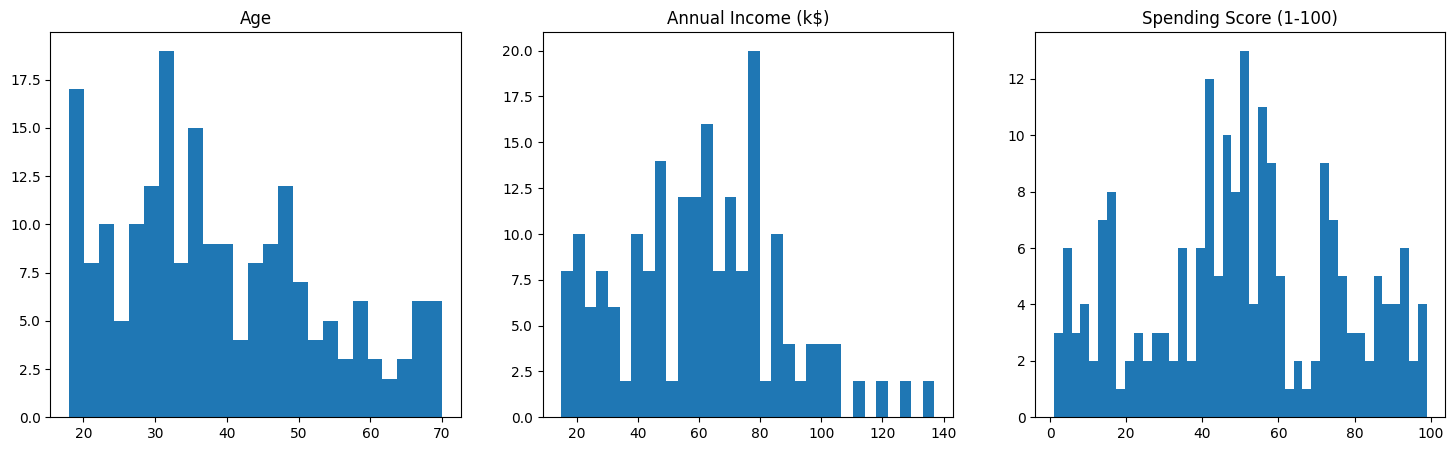

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

for (i, col) in enumerate(df.columns.drop("Gender")):
    unique = len(df[col].unique())
    axes[i].set_title(col)
    axes[i].hist(df[col], bins=unique//2)


## Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

m_df = df.copy()

standard_pp = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('standard', StandardScaler())
])

min_max_pp = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('min_max', MinMaxScaler())
])

categorical_pp = Pipeline([
    ('imputer', SimpleImputer(fill_value='missing', strategy='constant')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ('categorical', categorical_pp, ["Gender"]),
    ('standard', standard_pp, ["Age", "Annual Income (k$)"]),
    ('min_max', min_max_pp, ["Spending Score (1-100)"])
])

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Gender']),
                                ('standard',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('standard',
                                                  StandardScaler())]),
                                 ['Age', 'Annual Income (k$)']),
                                ('min_max',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('min_max', MinMaxScaler())]),
                                 ['Spending Score (1-100)'])])

In [20]:
m_df = pd.DataFrame(preprocessor.fit_transform(m_df), columns=m_df.columns)

In [21]:
m_df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,-1.424569,-1.738999,0.387755
1,1.0,-1.281035,-1.738999,0.816327
2,0.0,-1.352802,-1.700830,0.051020
3,0.0,-1.137502,-1.700830,0.775510
4,0.0,-0.563369,-1.662660,0.397959
...,...,...,...,...
195,0.0,-0.276302,2.268791,0.795918
196,0.0,0.441365,2.497807,0.275510
197,1.0,-0.491602,2.497807,0.744898
198,1.0,-0.491602,2.917671,0.173469


# **Model Building** 
*You will train and evaluate several unsupervised clustering models on the preprocessed data set, including k-means clustering and DBSCAN.*